In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def convert_data(file_path, output_dir):
    data = pd.read_csv(file_path, delimiter=',')
    data = data.iloc[:, :6]

    data.columns = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ']

    # 가속도 데이터 변환
    adxl345_range_value = 16  # ±16g
    adxl345_resolution = 13  # 13 bits
    adxl345_conversion_factor = (2 * adxl345_range_value) / (2 ** adxl345_resolution) 

    # 스마트워치 가속도 범위
    watch_acc_max_range = 78.4532

    # 스케일링
    data['accX'] = (data['accX'] * adxl345_conversion_factor * (watch_acc_max_range / adxl345_range_value)).round(2)
    data['accY'] = (data['accY'] * adxl345_conversion_factor * (watch_acc_max_range / adxl345_range_value)).round(2)
    data['accZ'] = (data['accZ'] * adxl345_conversion_factor * (watch_acc_max_range / adxl345_range_value)).round(2)

    # 각속도 데이터 변환
    itg3200_range_value = 2000  # ±2000 °/s
    itg3200_resolution = 16  # 16 bits
    itg3200_conversion_factor = (2 * itg3200_range_value) / (2 ** itg3200_resolution) 

    # 스마트워치 자이로스코프 범위
    watch_gyro_max_range = 17.453642

    # 스케일링
    data['gyroX'] = (data['gyroX'] * itg3200_conversion_factor * (watch_gyro_max_range / itg3200_range_value)).round(2)
    data['gyroY'] = (data['gyroY'] * itg3200_conversion_factor * (watch_gyro_max_range / itg3200_range_value)).round(2)
    data['gyroZ'] = (data['gyroZ'] * itg3200_conversion_factor * (watch_gyro_max_range / itg3200_range_value)).round(2)

    output_file_path = os.path.join(output_dir, os.path.basename(file_path))
    data.to_csv(output_file_path, index=False)

In [146]:
def process_directory(input_dir, output_base_dir, label):
    output_dir = os.path.join(output_base_dir, label)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.txt'):
                file_path = os.path.join(root, file)
                convert_data(file_path, output_dir)

In [148]:
directories = ['./D01', './D02', './D03', './D04','./D05', './D06', './D07', './D08', 
'./D09', './D10', './D11','./D12','./D13', './D14', './D15', './D16', './D17', './D18', './D18', './D19',
'./F01', './F02', './F03', './F04', './F05', './F06', './F07', './F08', './F09', './F10', './F11', './F12','./F13', './F14', './F15']
output_base_dir = './training_data'

# 각 디렉토리 처리
for directory in directories:
    label = 'false' if os.path.basename(directory).startswith('D') else 'true'
    process_directory(directory, output_base_dir, label)

In [142]:
import pandas as pd

file_path = 'training_data/false/D19_SA23_R01.txt'
file_name = 'D19'

df = pd.read_csv(file_path)

print(df.head())

   accX  accY  accZ  gyroX  gyroY  gyroZ
0  0.27 -4.98 -0.42  -0.06   0.02   0.10
1  0.36 -5.04 -0.56  -0.05   0.02   0.10
2  0.25 -4.98 -0.56  -0.05   0.02   0.09
3  0.27 -4.98 -0.63  -0.04   0.02   0.09
4  0.25 -4.98 -0.84  -0.04   0.02   0.09


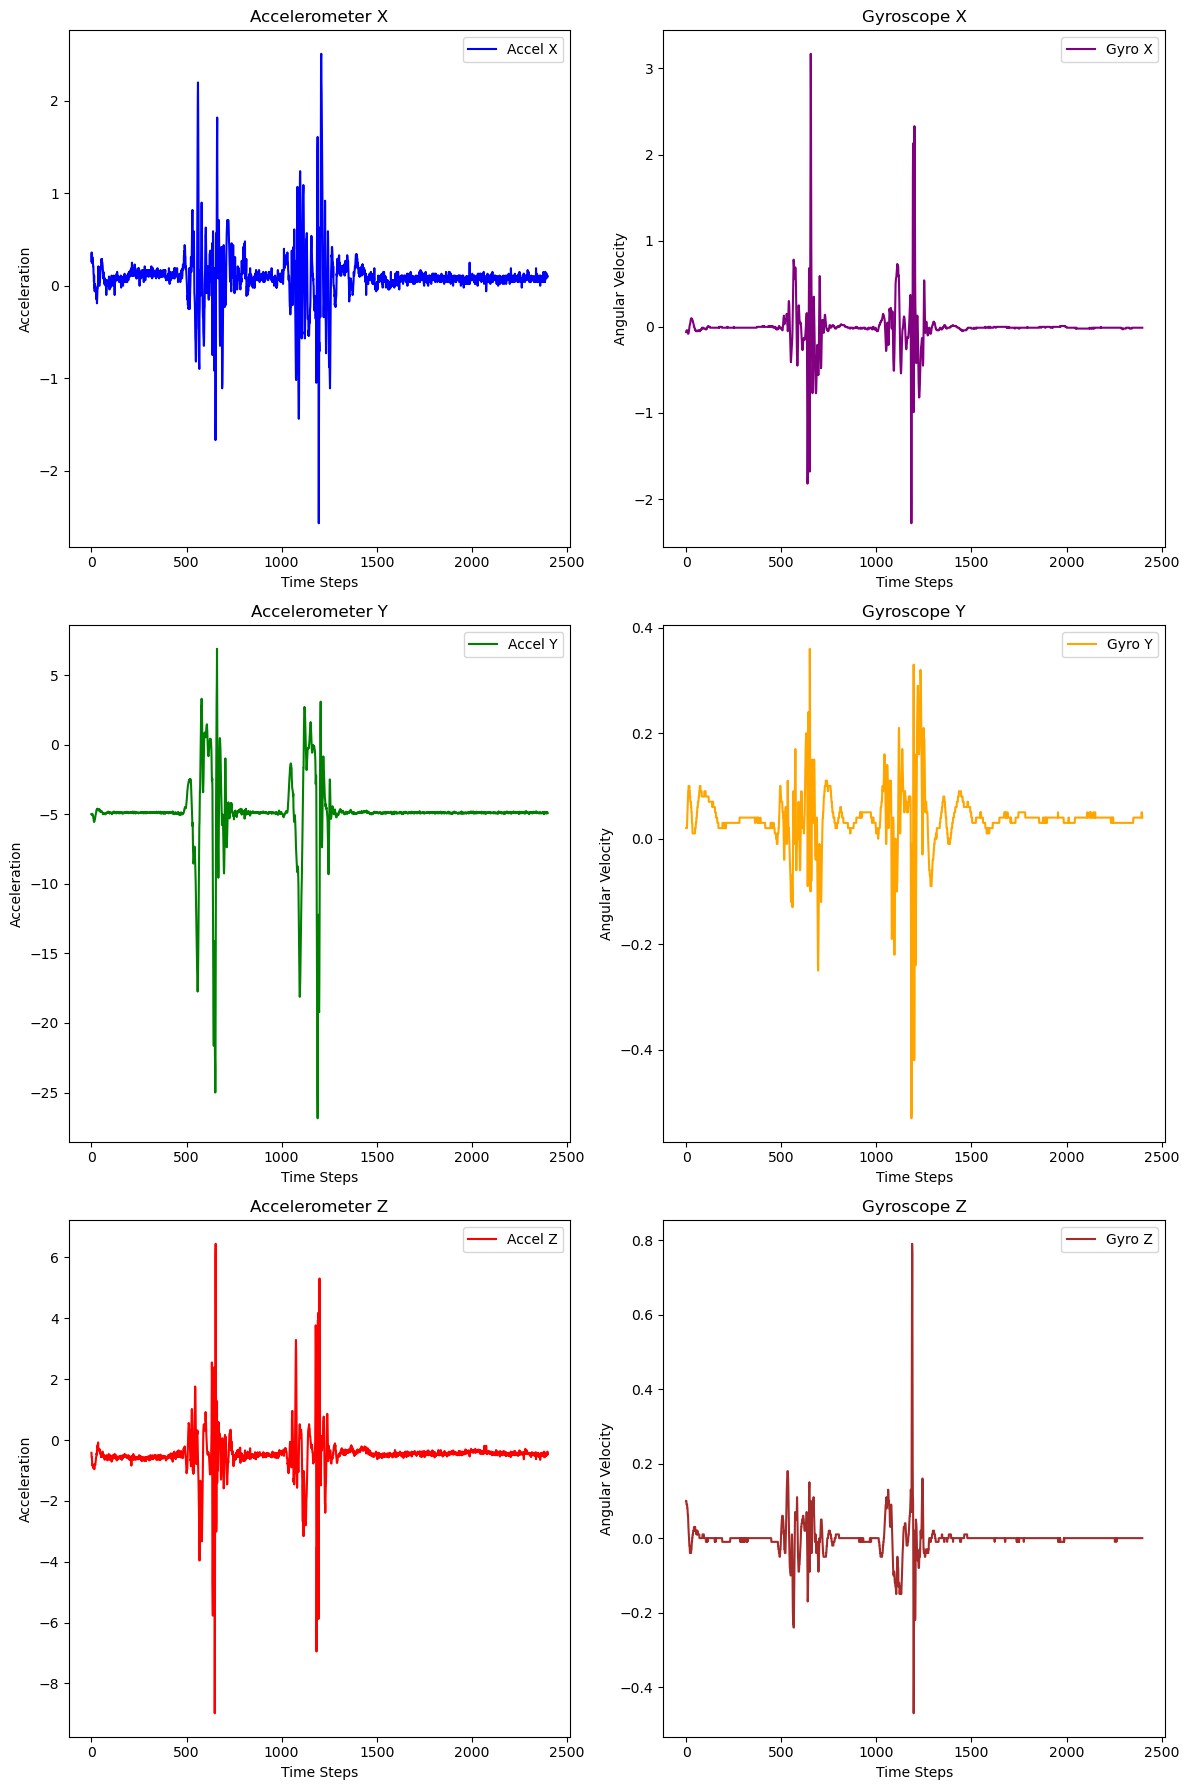

In [143]:
# 시각화
plt.figure(figsize=(12, 18)) 

# 가속도 X
plt.subplot(3, 2, 1)
plt.plot(df.index, df['accX'], label='Accel X', color='blue')
plt.title('Accelerometer X')
plt.xlabel('Time Steps')
plt.ylabel('Acceleration')
plt.legend()

# 가속도 Y
plt.subplot(3, 2, 3)
plt.plot(df.index, df['accY'], label='Accel Y', color='green')
plt.title('Accelerometer Y')
plt.xlabel('Time Steps')
plt.ylabel('Acceleration')
plt.legend()

# 가속도 Z
plt.subplot(3, 2, 5)
plt.plot(df.index, df['accZ'], label='Accel Z', color='red')
plt.title('Accelerometer Z')
plt.xlabel('Time Steps')
plt.ylabel('Acceleration')
plt.legend()

# 각속도 X
plt.subplot(3, 2, 2)
plt.plot(df.index, df['gyroX'], label='Gyro X', color='purple')
plt.title('Gyroscope X')
plt.xlabel('Time Steps')
plt.ylabel('Angular Velocity')
plt.legend()

# 각속도 Y
plt.subplot(3, 2, 4)
plt.plot(df.index, df['gyroY'], label='Gyro Y', color='orange')
plt.title('Gyroscope Y')
plt.xlabel('Time Steps')
plt.ylabel('Angular Velocity')
plt.legend()

# 각속도 Z
plt.subplot(3, 2, 6)
plt.plot(df.index, df['gyroZ'], label='Gyro Z', color='brown')
plt.title('Gyroscope Z')
plt.xlabel('Time Steps')
plt.ylabel('Angular Velocity')
plt.legend()

plt.tight_layout()
plt.savefig(file_name)
plt.show()

In [144]:
import os
import shutil

base_dir = '/Users/soobin/Downloads/SisFall_dataset'  
output_dir = '/Users/soobin/backend/dialog'  

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            prefix = file_name[:3]
            
            target_dir = os.path.join(output_dir, prefix)
            if not os.path.exists(target_dir):
                os.makedirs(target_dir)
            
            src_file = os.path.join(folder_path, file_name)
            dest_file = os.path.join(target_dir, file_name)
            shutil.move(src_file, dest_file)

print("파일 정리가 완료되었습니다.")

파일 정리가 완료되었습니다.
